In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

from tqdm.auto import tqdm
from scipy.stats import norm
from datetime import timedelta

# Задание 1

### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [154]:
def retention(file_reg, file_auth, start_date='', end_date='', lifetime=None, sep=','):
    """file_reg - файл с данными регистрации, file_auth - файл с данными о времени захода пользователей в игру, 
    sep - разделитель, используемый при чтении данных, по умолчанию ','. 
    Период даты регистрации пользователей задается параметрами start_date, end_date. По умолчанию период равен одной неделе.
    Период расчета retention указывается в lifetime. По умолчанию не ограничен."""
    df1 = pd.read_csv(file_reg, sep=sep)
    df2 = pd.read_csv(file_auth, sep=sep)
    
    # Приводим имена столбцов к стандартным названиям
    df1.rename(columns={df1.columns[0]: 'reg_ts', df1.columns[1]: 'uid'})
    df2.rename(columns={df2.columns[0]: 'reg_ts', df2.columns[1]: 'uid'})
    
    # Переводим время в нужный формат
    df1['reg_ts'] = pd.to_datetime(df1.reg_ts, unit='s')
    df2['auth_ts'] = pd.to_datetime(df2.auth_ts, unit='s')
    
    # Проверим, есть ли у одного пользователя две даты регистрации
    if df1.value_counts().sum() != df1.shape[0]:
        print('Warning!\nThe dataset with registration contains duplicates')
    
    # Далее удалим лишние строки, если такие имеются, где пользователь за один день заходил несколько раз
    df2['key'] = 0  # добавим колонку для простоты агрегирования
    df2 = df2.groupby(['uid', 'auth_ts'], as_index=False).agg({'key': 'count'}) \
        .drop('key', axis=1).merge(df2, how='inner', on=['uid', 'auth_ts']).drop('key', axis=1)
    
    # Соединим два датасета и высчитаем lifetime - разница в днях между датой входа и датой регистрации.
    df = df2.merge(df1, how='left', on='uid')
    df['lifetime'] = (df['auth_ts'] - df['reg_ts']).dt.days
    
    # Отберем только нужные данные
    if len(start_date) != 0 and len(end_date) != 0:
        start_date = start_date
        end_date = end_date
    else:
        start_date = max(df.reg_ts) - timedelta(days=7)
        end_date = max(df.reg_ts) + timedelta(days=1)
    df = df.query('reg_ts >= @start_date and reg_ts <= @end_date')
    if lifetime != None:
        df = df.query('lifetime <= @lifetime')
    pd.options.mode.chained_assignment = None
    df['auth_ts'] = df['auth_ts'].dt.date
    df['reg_ts'] = df['reg_ts'].dt.date
    
    # Рассчитываем retention
    df = df.groupby(['reg_ts', 'lifetime'], as_index=False).agg({'uid': 'count'})
    df_merge = df.query('lifetime == 0').rename(columns={'uid': 'total'})
    df_merge= df_merge[['reg_ts', 'total']]
    df = df.merge(df_merge, how='left', on='reg_ts')
    df['retention'] = df['uid'] / df['total']
    df = df[df['lifetime'] > 0]
    d = df.pivot('reg_ts', 'lifetime', 'retention')
    
    # Построим визуализацию
    sns.set(style="ticks")
    plt.figure(figsize=(24, 16))
    plt.title("Retention")
    sns.heatmap(d, mask=d.isnull(), annot=True, fmt=".2%")

### Запустим функцию без установки параметров, контролирующих дату регистрации пользователей, с периодом в 5 дней

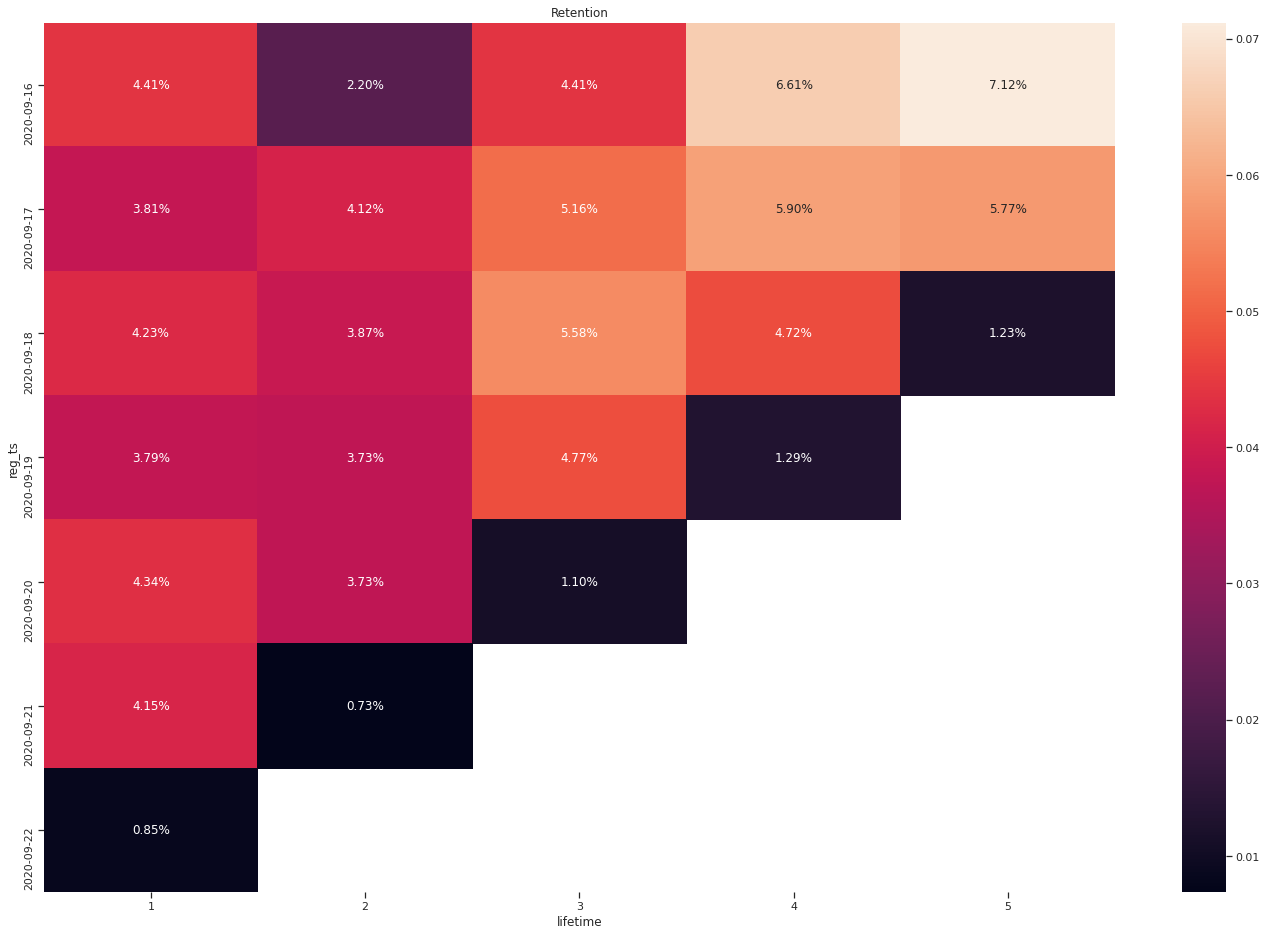

In [155]:
retention('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-radchenko-26/shared/problem1-reg_data.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-radchenko-26/shared/problem1-auth_data.csv', lifetime = 5, sep=';')

### Теперь запустим функцию с ограничением даты регистрации пользователей. 
### С 2020-09-01 по 2020-09-23.

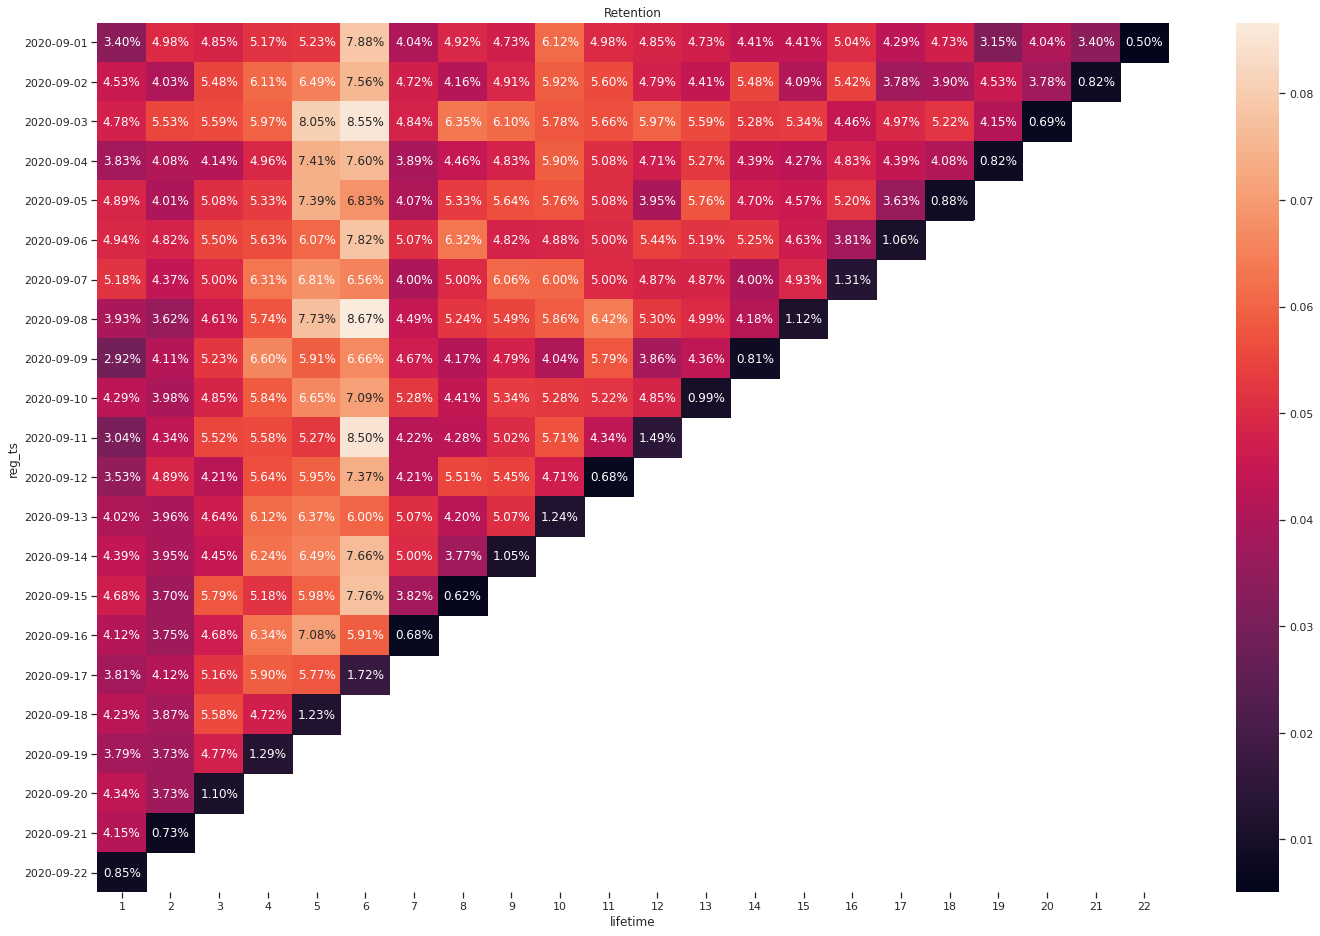

In [143]:
retention('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-radchenko-26/shared/problem1-reg_data.csv', '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-radchenko-26/shared/problem1-auth_data.csv', start_date='2020-09-01', end_date='2020-09-23', sep=';')

### lifetime - количество дней с момента регистрации
### retention - % возврата пользователей в этот день

# Задание 2

### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-radchenko-26/final_project_task2.csv', sep=';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
# Проверим пропуски в данных
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df_arpu = df.groupby('testgroup', as_index=False).agg({'revenue': 'sum', 'user_id': 'count'}) \
    .rename(columns={'user_id': 'number_of_users'})

df_arpu['arpu'] = df_arpu.revenue / df_arpu.number_of_users
df_arpu

,testgroup,revenue,number_of_users,arpu
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


### Из данных видна разница ARPU (средняя выручка на одного пользователя) в контрольной и тестовой группах. Проверим, статистическую значимость. 
### Для начала посмотрим на распределения revenue по группам

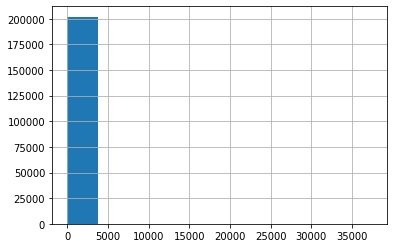

In [11]:
# Контрольная группа
df.query('testgroup == "a"').revenue.hist()

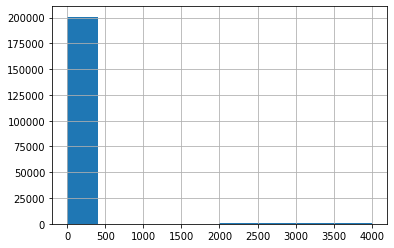

In [12]:
# Тестовая группа
df.query('testgroup == "b"').revenue.hist()

### Распределения далеки от нормальных, следовательно параметрические критерии для проверки значимости использовать не стоит. 
### Bootstrap c арифметическим средним тоже отсекаем, в связи с длинными хвостами распределений. Использование медианы в качестве статистики в нашем случае тоже не походит, тк медианы в обеих случаях равняются 0 из за особенности данных.
### Останавливается на непараметрическом критерии Манна-Уитни.

In [7]:
st.mannwhitneyu(df[df['testgroup'] == 'a'].revenue, df[df['testgroup'] == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

### p-value > 0.05, следовательно показатели выручки не имеют стат. значимых различий.

### Так как большинство пользователей имеют показатель revenue = 0, то имеет смысл посмотреть на метрику ARPPU (средняя выручка на одного платящего пользователя) и посмотреть в этом случае стат. значимые различия.
### Для этого отсортируем по revenue > 0

In [14]:
df_arppu = df[df['revenue'] > 0].groupby('testgroup', as_index=False).agg({'revenue': 'sum', 'user_id': 'count'}) \
    .rename(columns={'user_id': 'number_of_users'})

df_arppu['arppu'] = df_arppu.revenue / df_arppu.number_of_users
df_arppu

,testgroup,revenue,number_of_users,arppu
0,a,5136189,1928,2663.998444
1,b,5421603,1805,3003.658172


### Видно, что APRRU выше в тестовой группе. Определим стат. значимость данных различий. Построим распределения revenue > 0 по группам

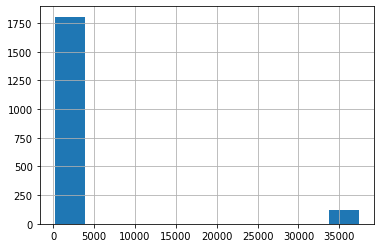

In [15]:
# Контрольная группа
df.query('testgroup == "a" and revenue > 0').revenue.hist()

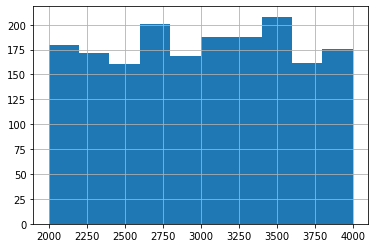

In [16]:
# Тестовая группа
df.query('testgroup == "b" and revenue > 0').revenue.hist()

### Для проверки стат значимости воспользуется bootstrap с медианой в качестве статистики, тк имеем распределения с длинным хвостом.

In [12]:
def get_bootstrap_median(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.median,  # интересующая нас статистика
    bootstrap_conf_level = 0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

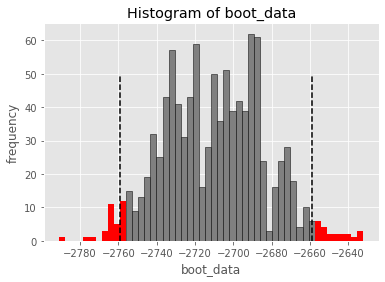

In [18]:
plt.style.use('ggplot')
%matplotlib inline

arppu_bootstrap = get_bootstrap_median(df.query('testgroup == "a" and revenue > 0').revenue, df.query('testgroup == "b" and revenue > 0').revenue)

In [19]:
arppu_bootstrap['p_value']

0.0

### Получили p-value < 0.05, следовательно можно сделать вывод о статистической значимости различий ARPPU

### Также не упустим тот факт, что выборки отличаются количеством платящих и неплатящих пользователей.
### Для этого рассмотрим различие к конверсиях в тестовой и контрольной группах

In [20]:
df_chi = df[['revenue', 'testgroup']]

pd.options.mode.chained_assignment = None
df_chi['revenue'] = df_chi['revenue'].astype(bool).astype(int)

df_chi.head()

,revenue,testgroup
0,0,b
1,0,a
2,0,a
3,0,b
4,0,b


In [21]:
df_chi

,revenue,testgroup
0,0,b
1,0,a
2,0,a
3,0,b
4,0,b
...,...,...
404765,0,a
404766,0,b
404767,1,a
404768,0,a


In [22]:
df_chi_q = pd.crosstab(columns=df_chi.testgroup, index=df_chi.revenue, values=df_chi.revenue, aggfunc='count')

In [23]:
df_chi_q

testgroup,a,b
revenue,,
0,200175,200862
1,1928,1805


### Для оценки значимости данных различий воспользуемся критерием Хи-квадрат

In [24]:
st.chi2_contingency(df_chi_q)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104, 200797.89924896],
        [  1863.89924896,   1869.10075104]]))

### p-value < 0.05, следовательно наблюдаются стат значимые различия. Теперь выясним у какой группы показатель конверсии больше

In [25]:
df_chi_q.a[1] / df_chi_q.a[0] > df_chi_q.b[1] / df_chi_q.b[0]

True

In [26]:
(df_chi_q.a[1] / df_chi_q.a[0] - df_chi_q.b[1] / df_chi_q.b[0]) * 100

0.06453031943376882

### Показатель конверсии в контрольной группе оказался статистически значимо больше на 0.065%

### После всех проведенных экспериментов, могу сделать вывод о том, что для ответа на вопрос какой набор акционных предложений можно считать лучшим в данном случае нужно учитывать стратегию компании по работе с клиентами. 
 - Если основным вектором развития компании считать переориентацию из низкого сегмента в более высокий (премиальный сегмент), то имеет смысл раскатить новые акционные предложения на всех клиентов. Данный вывод следует из достаточно резкого скачка метрики ARPPU + очень сильные выбросы в данных у исходной группы Б что также может быть сигналом, что нужно завоевывать более высокий сегмент пользователей. Снижение показателя конверсии следует от потери небольшой части пользователей, что свойственно при переориентации.
     
 - Если же нет, то я бы настаивал на повторении эксперимента, при возможности с увеличением времени на него, так как на данный момент нет причин раскатывать изменения, но это только в том случае, если сильные выбросы показателя revenue в контрольной группе это не случайная флуктуация, а закономерность.

# Задание 3

### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Отвечая на первую часть задания, я выделю несколько основных метрик, с помощью которых можно наиболее точно оценить результаты внедрения тематических событий:
1. Игровое время (Total Daily Play Time) - Рассчитаем ее так: суммарную продолжительность всех сессий в день нужно разделить на количество активных пользователей в этот день (DAU). Таким образом мы узнаем сколько пользователь в среднем в день проводит времени в приложении. С помощью сравнения показателей данной метрики в дни тематического события и в обычные дни, можно оценить, насколько пользователи заинтересованы в данном событии.
2. Вторая метрика является хорошим дополнением к первой - это липкость (Sticky Factor), рассчитывается как отношение количества уникальных пользователей в день к числу уникальных пользователей в месяц. Данная метрика позволит оценить вовлеченность пользователей и регулярность посещений приложения в момент проведения тематического события.
3. В дополнение ко второй метрике для полноты картины предложу возвратное удержание (Bracket-Dependent Return Retention) с дополнением full retention. Те будем замерять процент пользователей, которые заходили в приложение по такой схеме: удержание 4-го дня будет учитывать пользователя, который заходил в приложение 4 дня подряд в период с начала тематического события. Далее полученные показатели можно сравнить с обычным игровым периодом, который будет равен продолжительности тематического события.
4. Для оценки финансовой составляющей возьмем метрику - конверсию в платеж. (актуально если присутствуют внутриигровые покупки). Рассчитывается как отношение пользователей совершивших покупку ко всем пользователям. В расчет будем брать активных пользователей в период тематического события (активный - хотя бы один раз зашел в игру). Сравнивать будем с такой же метрикой посчитанной при такой же длительности в обычный период. С помощью нее оценим влияние тематического события на желание пожертвовать деньги в приложение.

При изменении механики события (при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад) предложу добавить в выше перечисленные метрики, метрику оттока (Churn Rate). Так можно будет оценить реакцию пользователей на изменение механики событий. Также можно добавить метрику CSAT (customer satisfaction score), таким образом можно будет получить фитбек от наиболее активных пользователей.